In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Modular network implementation

In the following cells, I implement in a modular way a feedforward neural network. Please study the code -- many network implementations follow a similar pattern.

In [3]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)


In [4]:
#training algorithms. They change the network!
def GD(net, X, Y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """
    Simple batch gradient descent
    """
    old_L = np.inf
    for i in range(max_iters):
        L, O, gradients = net.get_cost_and_gradient(X, Y)
        if old_L < L:
            print("Iter: %d, loss increased!!" % (i,))
        if (old_L - L)<tolerance:
            print("Tolerance level reached exiting")
            break
        if i % 1000 == 0:
            err_rate = (O.argmax(0) != Y).mean()
            print("At iteration %d, loss %f, train error rate %f%%" % (i, L, err_rate*100))
        for P,G in zip(net.parameters, gradients):
            P -= alpha * G
        old_L = L

In [5]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
    
    @property
    def parameters(self):
        return []
    
    @property
    def parameter_names(self):
        return []
    
    def get_gradients(self, dLdY, fprop_context):
        return []

class ReLULayer(Layer):
    def __init__(self, **kwargs):
        super(ReLULayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.maximum(X, 0.0)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        return dLdY * (Y>0)

    
class SoftMaxLayer(Layer):
    def __init__(self, **kwargs):
        super(SoftMaxLayer, self).__init__(**kwargs)
    
    def compute_probabilities(self, X):
        O = X - X.max(axis=0, keepdims=True)
        O = np.exp(O)
        O /= O.sum(axis=0, keepdims=True)
        return O
    
    def fprop_cost(self, X, Y):
        NS = X.shape[1]
        O = self.compute_probabilities(X)
        Cost = -1.0/NS * np.log(O[Y.ravel(), range(NS)]).sum()
        return Cost, O, dict(O=O, X=X, Y=Y)
    
    def bprop_cost(self, fprop_context):
        X = fprop_context['X']
        Y = fprop_context['Y']
        O = fprop_context['O']
        NS = X.shape[1]
        dLdX = O.copy()
        dLdX[Y, range(NS)] -= 1.0
        dLdX /= NS
        return dLdX
    
class FeedForwardNet(object):
    def __init__(self, layers=None):
        if layers is None:
            layers = []
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP[...] = newP
    
    @property
    def parameter_names(self):
        param_names = []
        for layer in self.layers:
            param_names += layer.parameter_names
        return param_names
    
    def fprop(self, X):
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
        return self.layers[-1].compute_probabilities(X)
    
    def get_cost_and_gradient(self, X, Y):
        fp_contexts = []
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
            fp_contexts.append(fp_context)
        
        L, O, fp_context = self.layers[-1].fprop_cost(X, Y)
        dLdX = self.layers[-1].bprop_cost(fp_context)
        
        dLdP = [] #gradient with respect to parameters
        for i in range(len(self.layers)-1):
            layer = self.layers[len(self.layers)-2-i]
            fp_context = fp_contexts[len(self.layers)-2-i]
            dLdP = layer.get_gradients(dLdX, fp_context) + dLdP
            dLdX = layer.bprop(dLdX, fp_context)
        return L, O, dLdP

class AffineLayer(Layer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(AffineLayer, self).__init__(**kwargs)
        if weight_init is None:
            weight_init = IsotropicGaussian()
        if bias_init is None:
            bias_init = Constant(0.0)
        
        self.W = weight_init.generate(self.rng, (num_out, num_in))
        self.b = bias_init.generate(self.rng, (num_out, 1))
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    @property
    def parameter_names(self):
        return ['W','b']
    
    def fprop(self, X):
        #Save X for later reusal
        fprop_context = dict(X=X)
        Y = np.dot(self.W, X) + self.b

        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        X = fprop_context['X']

        dLdX = np.dot(self.W.T, dLdY)
        
        return dLdX
    
    def get_gradients(self, dLdY, fprop_context):
        X = fprop_context['X']
        dLdW = np.dot(dLdY, X.T)
        dLdb = dLdY.sum(1, keepdims=True)
        return [dLdW, dLdb]
    
class TanhLayer(Layer):
    def __init__(self, **kwargs):
        super(TanhLayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.tanh(X)
        fprop_context = dict(Y=Y)

        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        
        dLdX = np.multiply((1 - Y ** 2), dLdY)
        
        return dLdX

In [6]:
from sklearn import datasets
iris = datasets.load_iris()
IrisX = iris.data.T
IrisX = (IrisX - IrisX.mean(axis=1, keepdims=True)) / IrisX.std(axis=1, keepdims=True)
IrisY = iris.target.reshape(1,-1)

In [7]:
#
# Here we verify that the network can be trained on Irises.
# Most runs should result in 100% accurracy
#

net = FeedForwardNet([
        AffineLayer(4,10),
        TanhLayer(),
        AffineLayer(10,3),
        SoftMaxLayer()
        ])

GD(net, IrisX,IrisY, 1e-1, tolerance=1e-7, max_iters=50000)

At iteration 0, loss 3.359489, train error rate 86.000000%
At iteration 1000, loss 0.049581, train error rate 2.000000%
At iteration 2000, loss 0.041246, train error rate 1.333333%
At iteration 3000, loss 0.038369, train error rate 1.333333%
At iteration 4000, loss 0.036796, train error rate 1.333333%
At iteration 5000, loss 0.035616, train error rate 1.333333%
At iteration 6000, loss 0.034553, train error rate 1.333333%
At iteration 7000, loss 0.033507, train error rate 1.333333%
At iteration 8000, loss 0.032438, train error rate 1.333333%
At iteration 9000, loss 0.031314, train error rate 1.333333%
At iteration 10000, loss 0.030045, train error rate 1.333333%
At iteration 11000, loss 0.028231, train error rate 1.333333%
At iteration 12000, loss 0.025405, train error rate 1.333333%
At iteration 13000, loss 0.022200, train error rate 0.666667%
At iteration 14000, loss 0.019178, train error rate 0.666667%
At iteration 15000, loss 0.016532, train error rate 0.666667%
At iteration 16000, 

# SGD

Your job is to implement SGD training on MNIST with the following elements:
1. SGD + momentum
2. weight decay
3. early stopping

In overall, you should get below 2% trainig errors

## Reading data from Fuel

The following cell prepares the data pipeline in fuel. please see SGD template for usage example

In [7]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (b.T for b in batch)], {}) )

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 100))
                                               
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 250))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 250))

In [8]:
print("The streams return batches containing %s" % (mnist_train_stream.sources,))

print("Each trainin batch consits of a tuple containing:")
for element in next(mnist_train_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))
    
print("Validation/test batches consits of tuples containing:")
for element in next(mnist_test_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

The streams return batches containing ('features', 'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (784, 100) containing float32
 - an array of size (1, 100) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (784, 250) containing float32
 - an array of size (1, 250) containing uint8


In [210]:
#
# Please note, the code blow is able to train a SoftMax regression model on mnist to poor results (ca 8%test error), 
# you must improve it
#

from copy import deepcopy

def compute_error_rate(net, stream):
    num_errs = 0.0
    num_examples = 0
    for X, Y in stream.get_epoch_iterator():
        O = net.fprop(X)
        num_errs += (O.argmax(0) != Y).sum()
        num_examples += X.shape[1]
    return num_errs/num_examples

def SGD(net, train_stream, validation_stream, test_stream, alpha0 = 1e-2, epsilon = 0.01, Lambda = 0.01, chart = False):
    i=0
    e=0
    
    #initialize momentum variables
    # Hint: you need one velocity matrix for each parameter
    velocities = [np.zeros_like(P) for P in net.parameters]
    
    best_valid_error_rate = np.inf
    best_params = deepcopy(net.parameters)
    best_params_epoch = 0
    
    train_erros = []
    train_loss = []
    validation_errors = []
    
    number_of_epochs = 3
    patience_expansion = 1.5
    
    try:
        while e < number_of_epochs: #This loop goes over epochs
            e += 1
            
            # First train on all data from this batch
            for X, Y in train_stream.get_epoch_iterator(): 
                i += 1
                
                L, O, gradients = net.get_cost_and_gradient(X, Y)
                err_rate = (O.argmax(0) != Y).mean()
                train_loss.append((i, L))
                train_erros.append((i, err_rate))
                
                #if i % 100 == 0:
                #    print("At minibatch %d, batch loss %f, batch error rate %f%%" % (i, L, err_rate*100))
                
                # Set a learning rate
                alpha = alpha0 * (1 - np.tanh(i * 0.549306 / 10000))
                
                for P, V, G, N in zip(net.parameters, velocities, gradients, net.parameter_names):
                    if N=='W':
                        # Set the decay coefficient.
                        #Lambda = 0.001
                        # Implement the weight decay addition to gradient
                        G += Lambda * P
                    
                    # The momentum constant 
                    #epsilon = 0.01
                    
                    # Implement velocity update in momentum
                    
                    V = epsilon * V - alpha * G
                    
                    #
                    # TODO: set a more sensible learning rule here,
                    # using your learning rate schedule and momentum
                    #
                    #!!!!! Need to modify the actual parameter here! 
                    P += V
                    
            # After an epoch compute validation error
            val_error_rate = compute_error_rate(net, validation_stream)
            if val_error_rate < best_valid_error_rate:
                number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
                best_valid_error_rate = val_error_rate
                best_params = deepcopy(net.parameters)
                best_params_epoch = e
                validation_errors.append((i,val_error_rate))
                
            print("After epoch %d: valid_err_rate: %.2f%% currently going to do %d epochs" %(
                    e, val_error_rate * 100, number_of_epochs), flush = True)
            
    except KeyboardInterrupt:
        print("Setting network parameters from after epoch %d" %(best_params_epoch))
        net.parameters = best_params
        
        if chart:
            subplot(2,1,1)
            train_loss = np.array(train_loss)
            semilogy(train_loss[:,0], train_loss[:,1], label='batch train loss')
            legend()

            subplot(2,1,2)
            train_erros = np.array(train_erros)
            plot(train_erros[:,0], train_erros[:,1], label='batch train error rate')
            validation_errors = np.array(validation_errors)
            plot(validation_errors[:,0], validation_errors[:,1], label='validation error rate', color='r')
            ylim(0,0.2)
            legend()

In [263]:
def instance(hidden, alpha, epsilon, _lambda, w1 = 1e-2, w2 = 1e-2, chart = False):
    net = FeedForwardNet([
            AffineLayer(784, hidden, weight_init = Uniform(mean = 0.0, width = w1)),
            ReLULayer(),
            AffineLayer(hidden, 10, weight_init = Uniform(mean = 0.0, width = w2)),
            ReLULayer(),
            SoftMaxLayer()
            ])

    SGD(net, mnist_train_stream, mnist_validation_stream, mnist_test_stream, alpha, epsilon, _lambda, chart)
    print("Test error rate: %.2f%%" % (compute_error_rate(net, mnist_test_stream) * 100, ))

After epoch 1: valid_err_rate: 16.39% currently going to do 3 epochs
After epoch 2: valid_err_rate: 13.83% currently going to do 4 epochs
After epoch 3: valid_err_rate: 13.25% currently going to do 5 epochs
After epoch 4: valid_err_rate: 4.34% currently going to do 7 epochs
After epoch 5: valid_err_rate: 3.21% currently going to do 8 epochs
After epoch 6: valid_err_rate: 3.33% currently going to do 8 epochs
After epoch 7: valid_err_rate: 2.63% currently going to do 11 epochs
After epoch 8: valid_err_rate: 2.48% currently going to do 13 epochs
After epoch 9: valid_err_rate: 2.59% currently going to do 13 epochs
After epoch 10: valid_err_rate: 2.58% currently going to do 13 epochs
After epoch 11: valid_err_rate: 2.57% currently going to do 13 epochs
After epoch 12: valid_err_rate: 2.45% currently going to do 19 epochs
After epoch 13: valid_err_rate: 2.15% currently going to do 20 epochs
After epoch 14: valid_err_rate: 2.13% currently going to do 22 epochs
After epoch 15: valid_err_rate: 

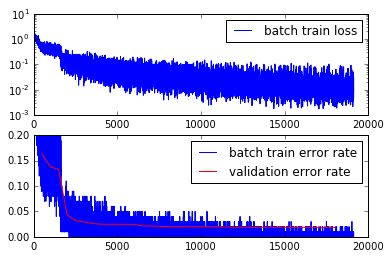

In [272]:
instance(384, 1e-1, 1, 0, 5e-2, 12e-2, True)

After epoch 1: valid_err_rate: 7.45% currently going to do 3 epochs
After epoch 2: valid_err_rate: 4.85% currently going to do 4 epochs
After epoch 3: valid_err_rate: 4.08% currently going to do 5 epochs
After epoch 4: valid_err_rate: 3.50% currently going to do 7 epochs
After epoch 5: valid_err_rate: 3.49% currently going to do 8 epochs
After epoch 6: valid_err_rate: 3.30% currently going to do 10 epochs
After epoch 7: valid_err_rate: 2.85% currently going to do 11 epochs
After epoch 8: valid_err_rate: 2.72% currently going to do 13 epochs
After epoch 9: valid_err_rate: 2.79% currently going to do 13 epochs
After epoch 10: valid_err_rate: 2.50% currently going to do 16 epochs
After epoch 11: valid_err_rate: 2.54% currently going to do 16 epochs
After epoch 12: valid_err_rate: 2.73% currently going to do 16 epochs
After epoch 13: valid_err_rate: 2.31% currently going to do 20 epochs
After epoch 14: valid_err_rate: 2.20% currently going to do 22 epochs
After epoch 15: valid_err_rate: 2.

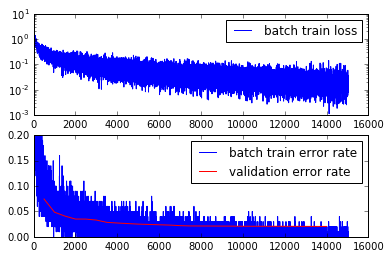

In [258]:
instance(256, 1e-1, 1, 1e-7, 5e-2, 1e-1, True)


After epoch 1: valid_err_rate: 7.34% currently going to do 3 epochs
After epoch 2: valid_err_rate: 5.25% currently going to do 4 epochs
After epoch 3: valid_err_rate: 4.26% currently going to do 5 epochs
After epoch 4: valid_err_rate: 3.96% currently going to do 7 epochs
After epoch 5: valid_err_rate: 3.31% currently going to do 8 epochs
After epoch 6: valid_err_rate: 3.04% currently going to do 10 epochs
After epoch 7: valid_err_rate: 2.93% currently going to do 11 epochs
After epoch 8: valid_err_rate: 3.11% currently going to do 11 epochs
After epoch 9: valid_err_rate: 2.96% currently going to do 11 epochs
After epoch 10: valid_err_rate: 2.65% currently going to do 16 epochs
After epoch 11: valid_err_rate: 2.31% currently going to do 17 epochs
After epoch 12: valid_err_rate: 2.40% currently going to do 17 epochs
After epoch 13: valid_err_rate: 2.51% currently going to do 17 epochs
After epoch 14: valid_err_rate: 2.24% currently going to do 22 epochs
After epoch 15: valid_err_rate: 2.

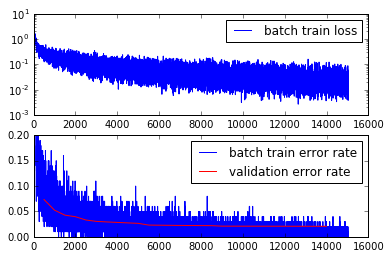

In [243]:
instance(128, 1e-1, 1, 1e-5, 5e-2, 1e-1, True)


After epoch 1: valid_err_rate: 7.79% currently going to do 3 epochs
After epoch 2: valid_err_rate: 6.03% currently going to do 4 epochs
After epoch 3: valid_err_rate: 5.21% currently going to do 5 epochs
After epoch 4: valid_err_rate: 4.20% currently going to do 7 epochs
After epoch 5: valid_err_rate: 3.92% currently going to do 8 epochs
After epoch 6: valid_err_rate: 3.83% currently going to do 10 epochs
After epoch 7: valid_err_rate: 3.58% currently going to do 11 epochs
After epoch 8: valid_err_rate: 3.30% currently going to do 13 epochs
After epoch 9: valid_err_rate: 3.13% currently going to do 14 epochs
After epoch 10: valid_err_rate: 3.17% currently going to do 14 epochs
After epoch 11: valid_err_rate: 3.05% currently going to do 17 epochs
After epoch 12: valid_err_rate: 3.03% currently going to do 19 epochs
After epoch 13: valid_err_rate: 3.10% currently going to do 19 epochs
After epoch 14: valid_err_rate: 2.85% currently going to do 22 epochs
After epoch 15: valid_err_rate: 3.

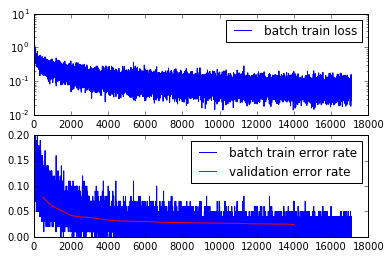

In [237]:
# tanh/relu
instance(100, 1e-1, 1, 1e-3, 5e-2, 1e-1, True)


After epoch 1: valid_err_rate: 8.96% currently going to do 3 epochs
After epoch 2: valid_err_rate: 7.36% currently going to do 4 epochs
After epoch 3: valid_err_rate: 6.74% currently going to do 5 epochs
After epoch 4: valid_err_rate: 6.29% currently going to do 7 epochs
After epoch 5: valid_err_rate: 5.59% currently going to do 8 epochs
After epoch 6: valid_err_rate: 5.65% currently going to do 8 epochs
After epoch 7: valid_err_rate: 4.98% currently going to do 11 epochs
After epoch 8: valid_err_rate: 5.04% currently going to do 11 epochs
After epoch 9: valid_err_rate: 4.64% currently going to do 14 epochs
After epoch 10: valid_err_rate: 4.39% currently going to do 16 epochs
After epoch 11: valid_err_rate: 4.45% currently going to do 16 epochs
After epoch 12: valid_err_rate: 4.28% currently going to do 19 epochs
After epoch 13: valid_err_rate: 4.05% currently going to do 20 epochs
After epoch 14: valid_err_rate: 3.94% currently going to do 22 epochs
After epoch 15: valid_err_rate: 3.9

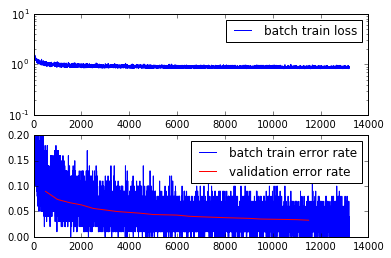

In [231]:
instance(100, 1e-1, 1, 1e-3, 5e-2, 1e-1, True)


In [223]:
instance(30, 1e-1, 1, 1e-3, 2e-1, 5e-2, False)
instance(30, 1e-1, 1, 1e-3, 1e-1, 5e-2, False)
instance(30, 1e-1, 1, 1e-3, 5e-2, 5e-2, False)
instance(30, 1e-1, 1, 1e-3, 2e-2, 5e-2, False)

After epoch 1: valid_err_rate: 9.26% currently going to do 3 epochs
Setting network parameters from after epoch 1
Test error rate: 9.45%
After epoch 1: valid_err_rate: 9.17% currently going to do 3 epochs
Setting network parameters from after epoch 1
Test error rate: 9.33%
After epoch 1: valid_err_rate: 9.69% currently going to do 3 epochs
Setting network parameters from after epoch 1
Test error rate: 9.95%
After epoch 1: valid_err_rate: 9.59% currently going to do 3 epochs
Setting network parameters from after epoch 1
Test error rate: 9.92%


After epoch 1: valid_err_rate: 9.76% currently going to do 3 epochs
After epoch 2: valid_err_rate: 8.11% currently going to do 4 epochs
After epoch 3: valid_err_rate: 7.64% currently going to do 5 epochs
After epoch 4: valid_err_rate: 6.86% currently going to do 7 epochs
After epoch 5: valid_err_rate: 6.17% currently going to do 8 epochs
After epoch 6: valid_err_rate: 5.79% currently going to do 10 epochs
After epoch 7: valid_err_rate: 5.57% currently going to do 11 epochs
After epoch 8: valid_err_rate: 5.18% currently going to do 13 epochs
After epoch 9: valid_err_rate: 4.77% currently going to do 14 epochs
After epoch 10: valid_err_rate: 4.82% currently going to do 14 epochs
After epoch 11: valid_err_rate: 4.49% currently going to do 17 epochs
After epoch 12: valid_err_rate: 4.43% currently going to do 19 epochs
After epoch 13: valid_err_rate: 4.19% currently going to do 20 epochs
After epoch 14: valid_err_rate: 4.14% currently going to do 22 epochs
Setting network parameters from af

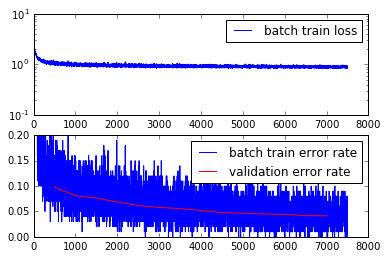

In [194]:
instance(300, 1e-1, 1, 1e-3, 1e-2)

In [276]:
print("{:.2%}".format(compute_error_rate(net, mnist_test_stream)))

12.95%
